# Анализ изменений мобильного приложения на группах пользователей

### Цели и задачи проекта

Мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения.
Необходимо изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого нужно исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Нужно выяснить, какой шрифт лучше.


### План проекта

- Шаг 1. Загрузка данных и изучение общей информации
- Шаг 2. Подготовка данных
- Шаг 3. Проверка данных
- Шаг 4. Исследование воронки событий
- Шаг 5. Анализ результатов эксперимента


### Описание данных

Путь к файлу: /datasets/logs_exp.csv

Каждая запись в логе — это действие пользователя, или событие.
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


### Загрузка  и подготовка данных

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import math as mth
from plotly import graph_objects as go


from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()



In [2]:
#Загружаем данные
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
df.head(10)
#Изменение названий столбцов
df.columns = ['event_name', 'user_id','datetimestamp','group'] 

In [3]:
#Добавление столбцов даты и времени, столбца с датой
df['datetime']=pd.to_datetime (df['datetimestamp'], unit='s')
df["date"] = df["datetime"].dt.date
df.info()
df.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   event_name     244126 non-null  object        
 1   user_id        244126 non-null  int64         
 2   datetimestamp  244126 non-null  int64         
 3   group          244126 non-null  int64         
 4   datetime       244126 non-null  datetime64[ns]
 5   date           244126 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


,event_name,user_id,datetimestamp,group,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
5,CartScreenAppear,6217807653094995999,1564055323,248,2019-07-25 11:48:43,2019-07-25
6,OffersScreenAppear,8351860793733343758,1564066242,246,2019-07-25 14:50:42,2019-07-25
7,MainScreenAppear,5682100281902512875,1564085677,246,2019-07-25 20:14:37,2019-07-25
8,MainScreenAppear,1850981295691852772,1564086702,247,2019-07-25 20:31:42,2019-07-25
9,MainScreenAppear,5407636962369102641,1564112112,246,2019-07-26 03:35:12,2019-07-26


In [4]:
#Ищем и удаляем дубликаты
df.duplicated().sum()


413

In [5]:
print(100*df.duplicated().sum()/df['event_name'].count())

0.16917493425526162


<div class="alert alert-info"> <b>Комментарий студента:</b> Доля дубликатов менее 0,2%. Величина не критичная, поэтому смело избавимся от них</div>

In [6]:
df = df.drop_duplicates()


#### Вывод по пункту

Данные были загружены. Проущенные значения отсутствуют. Названия заголовков привел к читабельному виду, интуитивно более подходящие по смыслу. Были удалены дубликаты. Добавил все столбца с датой/временем и датой

In [7]:
df.groupby('user_id').agg({'group': 'nunique'}).sort_values(by='group',ascending=False).head()

,group
user_id,
6888746892508752,1
6207768971558512760,1
6217807653094995999,1
6217295124800833842,1
6216080220799726690,1


<div class="alert alert-info"> <b>Комментарий студента:</b> Пересечений между пользователями нет. Каждый пользователь принадлежит одной группе</div>

### Изучение и проверка данных

In [8]:
df['event_name'].count()


243713

In [9]:
df['user_id'].nunique()

7551

In [10]:
#Находим число событий для каждого пользователя и считаем среднее
df_grouped = df.groupby('user_id', as_index=False).agg({'event_name': 'count'})
df_grouped['event_name'].mean()

32.27559263673685

In [11]:
df_grouped.describe()

,user_id,event_name
count,7.551000e+03,7551.000000
mean,4.677319e+18,32.275593
std,2.655343e+18,65.154219
min,6.888747e+15,1.000000
25%,2.397700e+18,9.000000
50%,4.688022e+18,20.000000
75%,7.007353e+18,37.000000
max,9.222603e+18,2307.000000


In [12]:
df['date'].min()

datetime.date(2019, 7, 25)

In [13]:
df['date'].max()

datetime.date(2019, 8, 7)

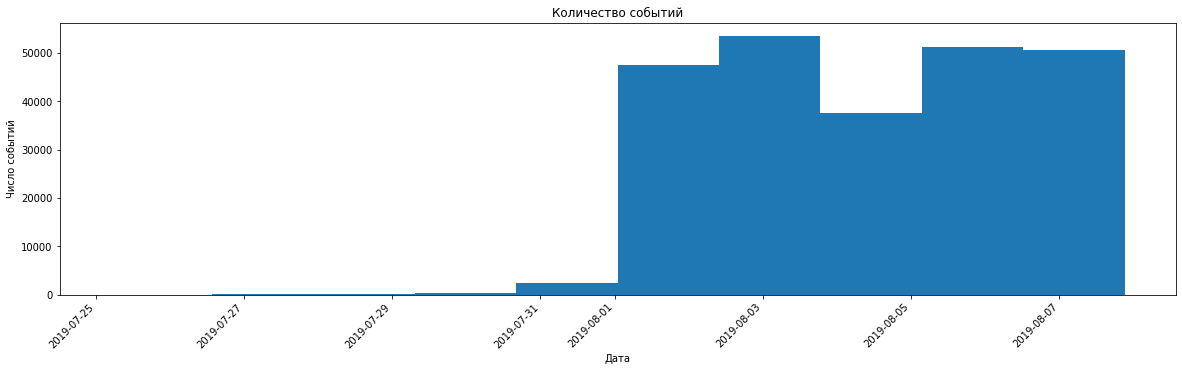

In [14]:
plt.figure(figsize=(20, 5))
plt.title('Количество событий')
plt.xlabel('Дата')
plt.ylabel('Число событий')
plt.xticks(rotation=45, horizontalalignment='right')
plt.hist(df['datetime'])
plt.show()


Гистограмма по дате и времени отражает неполноту данных за период с 25.07.2019 до 01.08.2019. Полнота в данных фиксируется с 01.08.2019

In [15]:
# Оставляем только полные данные
df_actual = df[(df['datetime'] > '2019-08-01')]


In [16]:
df_actual['event_name'].count()

240887

In [17]:
df_actual['user_id'].nunique()

7534

In [18]:
100*(1-df_actual['event_name'].count()/df['event_name'].count())

1.159560630741896

In [19]:
100*(1-df_actual['user_id'].nunique()/df['user_id'].nunique())

0.22513574361011646

<div class="alert alert-info"> <b>Комментарий студента:</b> Мы потеряли всего 0,22% пользователей и 1 % событий. Значения не существенные</div>

In [20]:
grouped_users = df_actual.groupby('group', as_index=False).agg({'user_id': 'nunique'})
grouped_users

,group,user_id
0,246,2484
1,247,2513
2,248,2537


c
После удаления дубликатов, число событий в датафрейме составляет 243713 шт. А число уникальных пользователей 7551. 
В среднем на пользователя приходится 32,28 события.
Период выборки с 25.07.2019 по 07.08.2019.

Гистограмма по дате и времени показала неполноту данных за период с 25.07.2019 до 01.08.2019. По этой причине, в дальнейшем выборка будет рассматриваться за период с 01.08.2019 по 07.08.2019. 
Число событий за этот период составляет 240887 шт.
Число уникальных пользователей незначительно сократилось с 7551 до 7534
Пользователи распределены по трем группам примерно в одинаковых количествах

### Изучение воронки событий

In [21]:
df_actual['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Всего в датафрейме 5 типов событий. Чаще всего фиксируется событие MainScreenAppear и меньше всех встречается событие Tutorial                      

In [22]:
event_grouped = df_actual.groupby('event_name', as_index=False).agg({'user_id': 'nunique'}).sort_values(by='user_id',ascending=False).reset_index(drop=True)


In [23]:
event_grouped['user_rate'] = round(100*event_grouped['user_id']/df_actual['user_id'].nunique(),2)
event_grouped.columns = ['event_name', 'cnt_user','user_rate'] 
event_grouped

,event_name,cnt_user,user_rate
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15



7419 пользователей открывали главную страницу приложения (MainScreenAppear), что составляет 98,47% от всех пользователей.
Возможно, остальные пользователи не смогли попасть на главную страницу из-за проблем с открытием, либо проблем с сетью у пользователей

Предполагаемая цепочка событий выглядит следующим образом:
- Пользователь открывает главную страницу приложения (MainScreenAppear)
- Открывает каталог для выбора товаров (OffersScreenAppear)
- Переходит в корзину (CartScreenAppear)
- Оформляет заказ, вводит данные карты(PaymentScreenSuccessful)

Событие Tutorial подразумевает под собой обучение пользователей по использованию приложения. Данное событие фиксировалось  у 11,15% пользователей. Из дальнейшего анализа воронки событий его нужно исключить

In [24]:
event_grouped = event_grouped[event_grouped['event_name'] != 'Tutorial']

for index in [1,2,3]:
    event_grouped.loc[0, 'next_step'] = round((100 * event_grouped.loc[0, 'cnt_user']/event_grouped.loc[0, 'cnt_user']),2)
    event_grouped.loc[index, 'next_step'] = round(100 * event_grouped.loc[index, 'cnt_user']/event_grouped.loc[index- 1, 'cnt_user'],2)

event_grouped



/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,event_name,cnt_user,user_rate,next_step
0,MainScreenAppear,7419,98.47,100.00
1,OffersScreenAppear,4593,60.96,61.91
2,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78


In [25]:
print (round(100 * event_grouped.loc[3, 'cnt_user']/event_grouped.loc[0, 'cnt_user'],2))

47.7


In [1]:
fig = go.Figure(go.Funnel(
    y = event_grouped['event_name'],
    x = event_grouped['cnt_user'],
    textposition = "inside",
    textinfo = "value+percent initial")
    )

fig.show()

NameError: name 'go' is not defined

Из воронки событий видим, что больше всего пользователей теряется на втором шаге - 61,91% доходят до выбора товаров. Возможно, интерфейс приложения выглядит неудобным, либо непонятным, как перейти в каталог.

До оплаты доходят 47,7% пользователей приложения

#### Вывод по пункту

В этом разделе мы посмотрели, какие события существуют, посчитали количество пользователей, совершавших эти события, построили цепочку событий, которые совершает пользователь при работе с приложением и проанализировали воронку событий. 

Глядя на эту воронку мы видим, что больше всего пользователей уходят от нас посмотрев на главный экран(MainScreenAppear) без перехода к каталогу товаров(OffersScreenAppear). Это может говорить о том что интерфейс основной страницы неудобен или некорректно отображается на части устройств.
От первого события до оплаты доходит меньше половины пользователей (47.7%)

### Изучение результатов эксперимента

In [27]:
df_new = df_actual[df_actual['event_name'] != 'Tutorial']

In [28]:
#Считаем количество пользователей в группах
df_new.groupby('group')['user_id'].nunique()

group
246    2483
247    2512
248    2535
Name: user_id, dtype: int64

In [29]:
df_new_grouped = df_new.groupby(['event_name','group'], as_index=False).agg({'user_id': 'nunique'}).sort_values(by='group',ascending=False).reset_index(drop=True)

#### Сравнение контрольных групп

In [30]:


def z_value_old(successes,trials,alpha):
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    #разница пропорций в датасетах
    difference = p1 - p2 
    alpha = alpha  # критический уровень статистической значимости
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        

In [31]:
group_users = df_new_grouped.pivot_table(
        index=['event_name'], 
        columns='group', 
        values='user_id',
        ).reset_index()
group_users[246247] = group_users[246]+group_users[247]

all_users = {
           246: df_new[df_new['group']==246]['user_id'].nunique(),
           247: df_new[df_new['group']==247]['user_id'].nunique(),
           248: df_new[df_new['group']==248]['user_id'].nunique(),
           246247: df_new[(df_new['group']==246) | (df_new['group']==247)]['user_id'].nunique()}

In [55]:
def z_value(first_group, second_group, alpha):
    for i in group_users.index:
        alpha = alpha
        p1 = group_users[first_group][i] / all_users[first_group]
        # пропорция успехов во второй группе:
        p2 = group_users[second_group][i] / all_users[second_group]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((group_users[first_group][i] + group_users[second_group][i]) / 
                      (all_users[first_group] + all_users[second_group]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/all_users[first_group] + 1/all_users[second_group]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(group_users['event_name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

In [56]:
z_value(246,247,0.05)

CartScreenAppear p-значение: 0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Для всех типов событий разница оказалась не значимой. Разбиение на группы работает корректно

#### Сравнение контрольной группы 246 с новой 248 

In [60]:
z_value(246,248,0.05)

CartScreenAppear p-значение: 0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Для всех типов событий разница оказалась не значимой

#### Сравнение контрольной группы 247 с новой 248

In [58]:
z_value(247,248,0.05)

CartScreenAppear p-значение: 0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Для всех типов событий разница оказалась не значимой

#### Сравнение объединенных контрольных групп с новой

In [61]:
z_value(246247,248,0.05)

CartScreenAppear p-значение: 0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Для всех типов событий разница оказалась не значимой

In [37]:
z_value(246,247,0.05/16)

CartScreenAppear p-значение: 0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [38]:
z_value(246,248,0.05/16)

CartScreenAppear p-значение: 0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [39]:
z_value(247,248,0.05/16)

CartScreenAppear p-значение: 0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [44]:
z_value(246247,248,0.05/16)

CartScreenAppear p-значение: 0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



### Вывод

Нами была проделена работа по анализу поведения пользователей в мобильном приложении.
Мы загрузили и подготовили данные для дальнейшей работы, проверили на пустые значения, отбросили дубликаты, потеряв при этом менее 1% пользователей.

Построили гистограмму, на основании которой, отбросили периоды с неполными данными.
Затем была построена воронка событий. 
При исследовании воронки событий мы выяснили, что от первого события до оплаты доходит всего 47.7% пользователей
98,47% от всех пользователей открывали главную страницу приложения (возможно прочие пользователи не смогли попасть на главную страницу из-за сетевых ошибок/некорректной работы приложения).
39% пользователей не открывали каталог товаров. Необходимо разобраться с причиной

Были осуществлены проверки статистических гипотез с уровнем значимости 0.05 между группами. И ни одна из них не выявила значимой разницы

По результатам A/A/B-эксперимента, можно сделать вывод, что изменение шрифта не оказало эффекта на пользователей. Поэтому нельзя судить о том, какой шрифт лучше.

Рекомендация заказчику: проверить работу приложения на нескольких устройств. Необходимо понять, почему много пользователей не доходят даже до открытия каталога товаров. Возможно на некоторых устройствах приложения работают некорректно, либо каталог находится в труднодоступном месте